<a href="https://colab.research.google.com/github/Noob-Coder2/Network-Traffic-Prediction/blob/main/Centralized_ResNet_Benchmark_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
TensorFlow Version: 2.19.0
Dataset loaded successfully from '/content/drive/MyDrive/Network Application Prediction/consolidated_NonVPN.csv'.


[I 2025-08-11 08:59:53,265] A new study created in memory with name: no-name-fec2ea48-4826-48d4-bbb9-08cc3af7c22f



Preprocessing complete.

--- Starting Hyperparameter Optimization for ResNet ---


[I 2025-08-11 09:02:41,066] Trial 0 finished with value: 0.9451360106468201 and parameters: {'units_1': 64, 'units_2': 64, 'dropout_rate': 0.49725480415991063, 'learning_rate': 0.0009885195458172922, 'batch_size': 32}. Best is trial 0 with value: 0.9451360106468201.
[I 2025-08-11 09:06:10,213] Trial 1 finished with value: 0.9633471369743347 and parameters: {'units_1': 256, 'units_2': 64, 'dropout_rate': 0.4075435250919309, 'learning_rate': 0.0015923795166333272, 'batch_size': 128}. Best is trial 1 with value: 0.9633471369743347.
[I 2025-08-11 09:07:23,530] Trial 2 finished with value: 0.9529737234115601 and parameters: {'units_1': 64, 'units_2': 128, 'dropout_rate': 0.31618153702340734, 'learning_rate': 0.006073607833331574, 'batch_size': 128}. Best is trial 1 with value: 0.9633471369743347.
[I 2025-08-11 09:09:48,171] Trial 3 finished with value: 0.9495158791542053 and parameters: {'units_1': 64, 'units_2': 64, 'dropout_rate': 0.323689768379272, 'learning_rate': 0.0004277046009620163,


Optimization finished.
Best trial:
  Validation Accuracy: 0.9633
  Best Hyperparameters: 
    units_1: 256
    units_2: 64
    dropout_rate: 0.4075435250919309
    learning_rate: 0.0015923795166333272
    batch_size: 128

--- Training Final Tuned ResNet Model ---
Epoch 1/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.7280 - loss: 0.8146 - val_accuracy: 0.8562 - val_loss: 0.4131
Epoch 2/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8733 - loss: 0.3686 - val_accuracy: 0.9032 - val_loss: 0.2719
Epoch 3/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8915 - loss: 0.3102 - val_accuracy: 0.9101 - val_loss: 0.2419
Epoch 4/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8979 - loss: 0.2912 - val_accuracy: 0.9170 - val_loss: 0.2249
Epoch 5/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9088 - loss: 0.2642 - val_accuracy: 0.9295 - val_loss: 0.2103
Epoch 6/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9066 - loss: 0.27

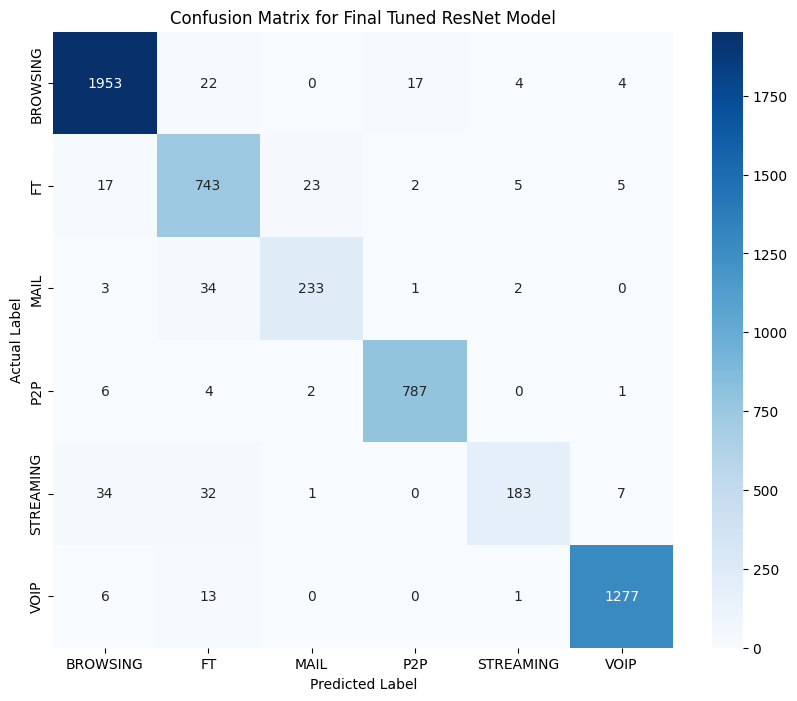

In [ ]:
# ==============================================================================
# Cell 1: Installation
# ==============================================================================
# Install necessary libraries, including Optuna for hyperparameter optimization.
!pip install -q tensorflow scikit-learn pandas matplotlib seaborn optuna

# ==============================================================================
# Cell 2: Imports & Drive Mount
# ==============================================================================
# Import all necessary libraries for the project.
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import optuna
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, QuantileTransformer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

print("TensorFlow Version:", tf.__version__)

# ==============================================================================
# Cell 3: Data Loading and Preprocessing
# ==============================================================================
# This cell uses the identical, successful preprocessing pipeline.

# --- Define paths and load data from your Drive ---
DRIVE_PATH = '/content/drive/MyDrive/Network Application Prediction/'
DATASET_PATH = os.path.join(DRIVE_PATH, 'consolidated_NonVPN.csv')

try:
    df = pd.read_csv(DATASET_PATH)
    print(f"Dataset loaded successfully from '{DATASET_PATH}'.")
except FileNotFoundError:
    print(f"Error: Dataset not found at '{DATASET_PATH}'. Please check the path.")
    df = pd.DataFrame()

if not df.empty:
    # Remove the noisy 'CHAT' class
    df = df[df['traffic_type'] != 'CHAT'].copy()

    # Initial Feature Engineering
    epsilon = 1e-6
    df['avg_packet_size'] = df['flowBytesPerSecond'] / (df['flowPktsPerSecond'] + epsilon)
    df['active_idle_ratio'] = df['mean_active'] / (df['mean_idle'] + epsilon)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)

    # Label Encoding
    label_encoder = LabelEncoder()
    df['traffic_type_encoded'] = label_encoder.fit_transform(df['traffic_type'])
    num_classes = len(label_encoder.classes_)

    # Separate features and target
    X_features = df.drop(columns=['traffic_type', 'traffic_type_encoded'])
    y = df['traffic_type_encoded']

    # Quantile Transformation
    qt = QuantileTransformer(output_distribution='normal', n_quantiles=min(1000, len(X_features)-1))
    X_final = pd.DataFrame(qt.fit_transform(X_features), columns=X_features.columns)

    # Align indices
    y.reset_index(drop=True, inplace=True)
    X_final.reset_index(drop=True, inplace=True)

    # Data Splitting and Scaling
    X_train, X_test, y_train, y_test = train_test_split(
        X_final, y, test_size=0.2, random_state=42, stratify=y
    )

    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_final.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X_final.columns)
    print("\nPreprocessing complete.")

# ==============================================================================
# Cell 4: Define the Optuna Objective Function for ResNet
# ==============================================================================
# This function defines one "trial" for the hyperparameter search.

def resnet_block(input_layer, units, dropout_rate):
    x = layers.Dense(units)(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(units)(x)
    x = layers.BatchNormalization()(x)
    shortcut = layers.Dense(units)(input_layer)
    shortcut = layers.BatchNormalization()(shortcut)
    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    return x

def objective(trial):
    """Defines the search space and trains a ResNet model for one trial."""
    num_features = X_train.shape[1]

    # --- Define the hyperparameter search space ---
    units_1 = trial.suggest_categorical('units_1', [64, 128, 256])
    units_2 = trial.suggest_categorical('units_2', [32, 64, 128])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    # --- CHANGE IS HERE 1: Tune the batch size ---
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])

    # Build the model using the suggested parameters
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, clipnorm=1.0)
    inputs = layers.Input(shape=(num_features,))
    x = resnet_block(inputs, units=units_1, dropout_rate=dropout_rate)
    x = resnet_block(x, units=units_2, dropout_rate=dropout_rate)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Create a validation set for early stopping
    X_train_part, X_val, y_train_part, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

    model.fit(X_train_part, y_train_part,
              epochs=100, # Train for up to 100 epochs
              batch_size=batch_size,
              validation_data=(X_val, y_val),
              callbacks=[early_stopping],
              verbose=0)

    # Evaluate on the validation set
    loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
    return accuracy

# ==============================================================================
# Cell 5: Run the Hyperparameter Optimization Study
# ==============================================================================
# This cell launches the Optuna study to find the best parameters.

if not df.empty:
    print("\n--- Starting Hyperparameter Optimization for ResNet ---")
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=30) # Run for 30 trials to find a good combination

    print("\nOptimization finished.")
    print("Best trial:")
    best_trial = study.best_trial
    print(f"  Validation Accuracy: {best_trial.value:.4f}")
    print("  Best Hyperparameters: ")
    for key, value in best_trial.params.items():
        print(f"    {key}: {value}")
    best_params = best_trial.params

# ==============================================================================
# Cell 6: Train and Evaluate the Final, Tuned ResNet Model
# ==============================================================================
# Now we train one final model using the best parameters found by Optuna.

if not df.empty:
    print("\n--- Training Final Tuned ResNet Model ---")

    # Build the final model with the best hyperparameters
    final_optimizer = tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate'], clipnorm=1.0)
    inputs = layers.Input(shape=(X_train.shape[1],))
    x = resnet_block(inputs, units=best_params['units_1'], dropout_rate=best_params['dropout_rate'])
    x = resnet_block(x, units=best_params['units_2'], dropout_rate=best_params['dropout_rate'])
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    final_model = tf.keras.Model(inputs=inputs, outputs=outputs)

    final_model.compile(optimizer=final_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # --- CHANGE IS HERE 2: Use EarlyStopping for robust final training ---
    # Create a final validation set to monitor for early stopping
    X_train_final, X_val_final, y_train_final, y_val_final = train_test_split(X_train, y_train, test_size=0.1, random_state=42, stratify=y_train)
    final_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

    # Train on 90% of the training data, validating on the other 10%
    final_model.fit(X_train_final, y_train_final,
                    epochs=100, # Train for up to 100 epochs
                    batch_size=best_params['batch_size'],
                    validation_data=(X_val_final, y_val_final),
                    callbacks=[final_early_stopping],
                    verbose=1)

    print("\n--- Evaluating Final Tuned ResNet Model ---")
    y_pred_probs = final_model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    final_accuracy = accuracy_score(y_test, y_pred)

    print(f"\nFinal Tuned ResNet Accuracy: {final_accuracy:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title('Confusion Matrix for Final Tuned ResNet Model')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()


Mounted at /content/drive
TensorFlow Version: 2.19.0
Dataset loaded successfully from '/content/drive/MyDrive/Network Application Prediction/consolidated_NonVPN.csv'.

Original dataset size: 29613
Dataset size after removing 'CHAT' class: 27108

Found 6 unique traffic types after removal.
Applying Quantile Transformation...

Preprocessing complete.
Final training set shape: (21686, 25)

ResNet model defined.

--- Training Centralized ResNet Model ---
Epoch 1/100
610/610 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.6696 - loss: 0.9627 - val_accuracy: 0.8658 - val_loss: 0.3707
Epoch 2/100
610/610 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8411 - loss: 0.4692 - val_accuracy: 0.8815 - val_loss: 0.3238
Epoch 3/100
610/610 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8576 - loss: 0.4078 - val_accuracy: 0.8930 - val_loss: 0.2947
Epoch 4/100
610/610 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8706 - loss: 0.3719 - val_accuracy: 0.9050 - val_loss: 0.2837
Epoch 5/100
610/610 ━━━━━━━━━

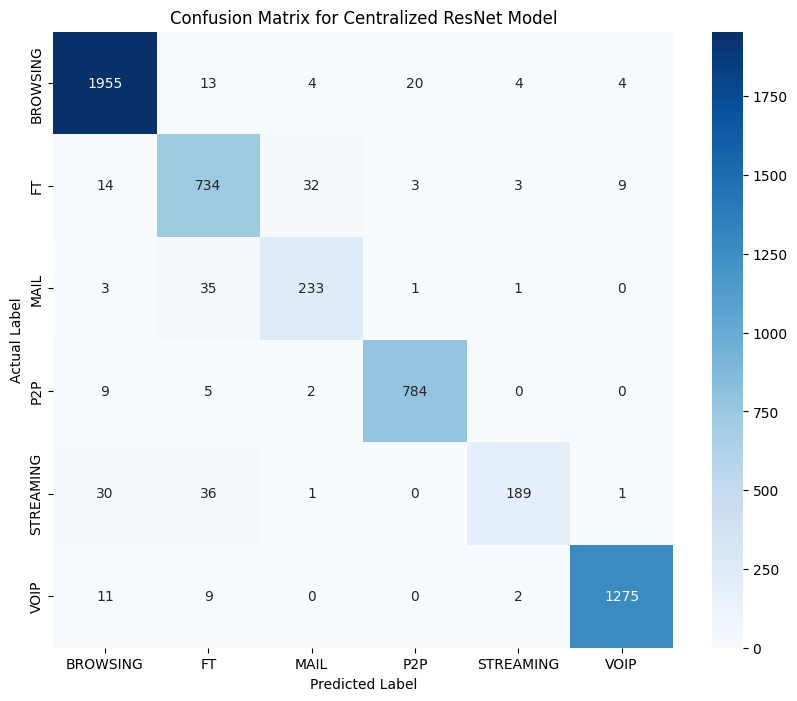

In [ ]:
# ==============================================================================
# Cell 1: Installation
# ==============================================================================
# Install necessary libraries.
!pip install -q tensorflow scikit-learn pandas matplotlib seaborn

# ==============================================================================
# Cell 2: Imports & Drive Mount
# ==============================================================================
# Import all necessary libraries for the project.
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, QuantileTransformer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

print("TensorFlow Version:", tf.__version__)

# ==============================================================================
# Cell 3: Data Loading and Preprocessing
# ==============================================================================
# This cell uses the IDENTICAL preprocessing pipeline as your federated notebook
# to ensure a fair and direct comparison.

# --- Define paths and load data from your Drive ---
DRIVE_PATH = '/content/drive/MyDrive/Network Application Prediction/'
DATASET_PATH = os.path.join(DRIVE_PATH, 'consolidated_NonVPN.csv')

try:
    df = pd.read_csv(DATASET_PATH)
    print(f"Dataset loaded successfully from '{DATASET_PATH}'.")
except FileNotFoundError:
    print(f"Error: Dataset not found at '{DATASET_PATH}'. Please check the path.")
    df = pd.DataFrame()

if not df.empty:
    # Remove the noisy 'CHAT' class
    print(f"\nOriginal dataset size: {len(df)}")
    df = df[df['traffic_type'] != 'CHAT'].copy()
    print(f"Dataset size after removing 'CHAT' class: {len(df)}")

    # 1. Initial Feature Engineering
    epsilon = 1e-6
    df['avg_packet_size'] = df['flowBytesPerSecond'] / (df['flowPktsPerSecond'] + epsilon)
    df['active_idle_ratio'] = df['mean_active'] / (df['mean_idle'] + epsilon)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)

    # 2. Label Encoding for the target
    label_encoder = LabelEncoder()
    df['traffic_type_encoded'] = label_encoder.fit_transform(df['traffic_type'])
    num_classes = len(label_encoder.classes_)
    print(f"\nFound {num_classes} unique traffic types after removal.")

    # 3. Separate features and target
    X_features = df.drop(columns=['traffic_type', 'traffic_type_encoded'])
    y = df['traffic_type_encoded']

    # 4. Apply Quantile Transformation
    print("Applying Quantile Transformation...")
    qt = QuantileTransformer(output_distribution='normal', n_quantiles=min(1000, len(X_features)-1))
    X_final = pd.DataFrame(qt.fit_transform(X_features), columns=X_features.columns)

    # 5. Align indices before splitting
    y.reset_index(drop=True, inplace=True)
    X_final.reset_index(drop=True, inplace=True)

    # 6. Data Splitting and Scaling
    X_train, X_test, y_train, y_test = train_test_split(
        X_final, y, test_size=0.2, random_state=42, stratify=y
    )

    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_final.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X_final.columns)
    print("\nPreprocessing complete.")
    print(f"Final training set shape: {X_train.shape}")

# ==============================================================================
# Cell 4: Define the ResNet Model
# ==============================================================================
# This cell defines the robust ResNet architecture, identical to the one in the
# federated notebook.

def resnet_block(input_layer, units, dropout_rate=0.3):
    x = layers.Dense(units)(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(units)(x)
    x = layers.BatchNormalization()(x)
    shortcut = layers.Dense(units)(input_layer)
    shortcut = layers.BatchNormalization()(shortcut)
    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    return x

def create_resnet_model():
    num_features = X_train.shape[1]
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0)
    inputs = layers.Input(shape=(num_features,))
    x = resnet_block(inputs, units=64)
    x = resnet_block(x, units=32)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

print("\nResNet model defined.")

# ==============================================================================
# Cell 5: Train the Centralized ResNet Model
# ==============================================================================
# This cell trains the ResNet model on the entire training dataset.

if not df.empty:
    print("\n--- Training Centralized ResNet Model ---")

    # Create an instance of the model
    resnet_model = create_resnet_model()

    # Define an early stopping callback to prevent overfitting
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train the model
    history = resnet_model.fit(
        X_train, y_train,
        epochs=100, # Train for a large number of epochs, early stopping will find the best one
        batch_size=32,
        validation_split=0.1,
        callbacks=[early_stopping],
        verbose=1
    )

    print("\nModel training complete.")

# ==============================================================================
# Cell 6: Evaluate the Centralized ResNet Benchmark
# ==============================================================================
# This cell evaluates the model's performance to establish our direct benchmark.

if not df.empty:
    print("\n--- Evaluating Centralized ResNet Benchmark ---")

    # 1. Make predictions on the test set
    y_pred_probs = resnet_model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # 2. Calculate and print accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\nCentralized ResNet Benchmark Accuracy: {accuracy:.4f}")

    # 3. Print a detailed classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    # 4. Visualize the Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.title('Confusion Matrix for Centralized ResNet Model')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()